#**BACHIR_Exam_TP**
#**Time Series Analysis**
Time series analysis can be used in a multitude of business applications for forecasting a quantity into the future and explaining its historical patterns. Here are just a few examples of possible use cases:

Explaining seasonal patterns in sales
Predicting the expected number of incoming or churning customers
Estimating the effect of a newly launched product on number of sold units
An ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data:

**AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations (p).

- I: Integrated. The use of differencing (d) of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model (q) applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.
If our model has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P,D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model. In particular, Statsmodel provides a Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model.

The process of fitting an ARIMA model is sometimes referred to as the Box-Jenkins method.

This tutorial uses content from Dalinina, 2017 and covers the following topics:

Examine your data
Plot the data and examine its patterns and irregularities
Clean up any outliers or missing values if needed
Take a logarithm of a series to help stabilize a strong growth trend
Decompose your data
Does the series appear to have trends or seasonality?
Use decompose() to examine and possibly remove components of the series
Stationarity
Is the series stationary?
Use ACF, PACF plots to determine order of differencing needed
Autocorrelations and choosing model order
Choose order of the ARIMA by examining ACF and PACF plots
Fit a model (ARIMA and SARIMAX)
Evaluate and iterate
Calculate forecast with SARIMAX

In [177]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# seed configuration
np.random.seed(38)
torch.manual_seed(38)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from sklearn.metrics import mean_squared_error

In [181]:
df = pd.read_excel("/content/Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [182]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [133]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

##**Data Preprocessing**
This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [134]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [135]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

###**Indexing with Time Series Data**

In [136]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

####Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [137]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 furniture sales data.

In [138]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

##**Visualizing Furniture Sales Time Series Data**

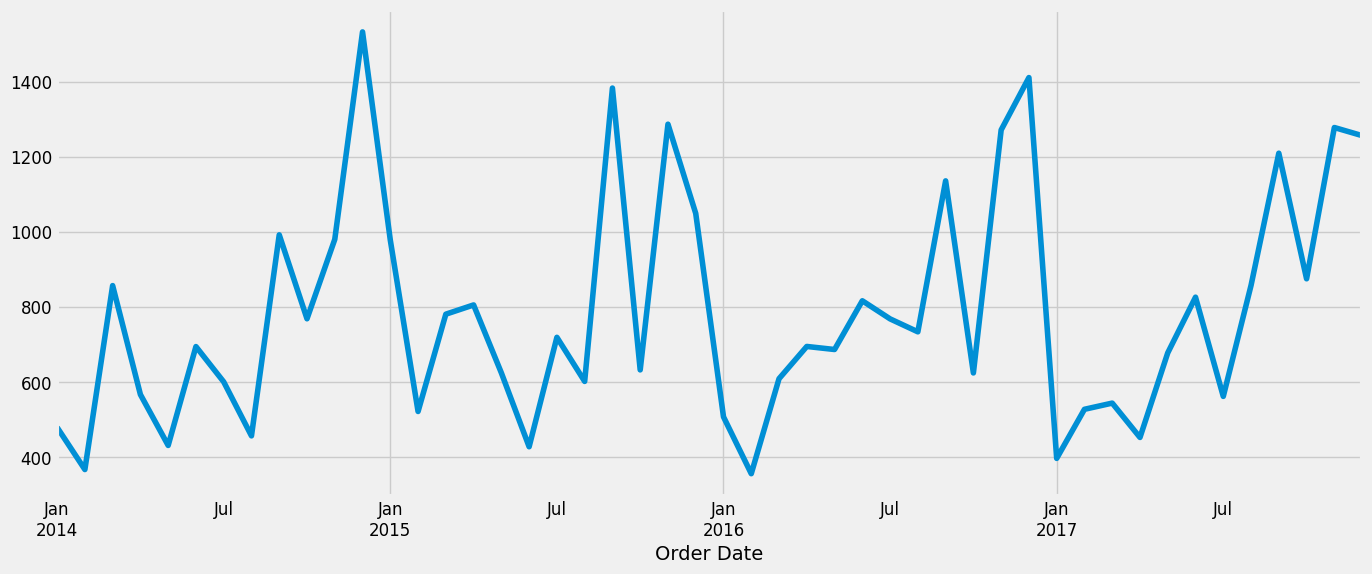

In [139]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

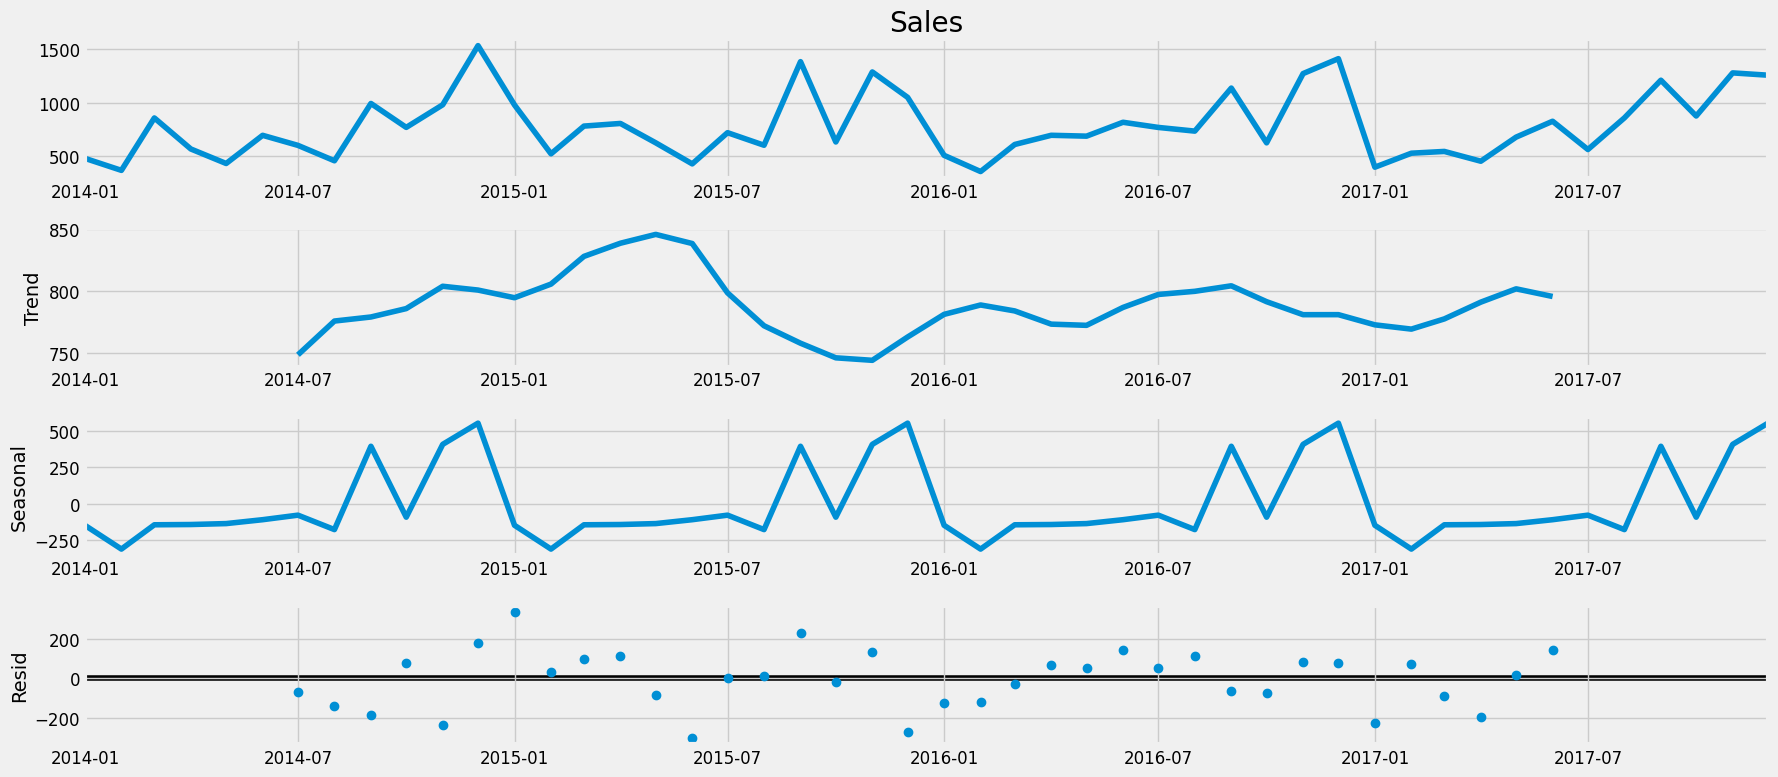

In [140]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

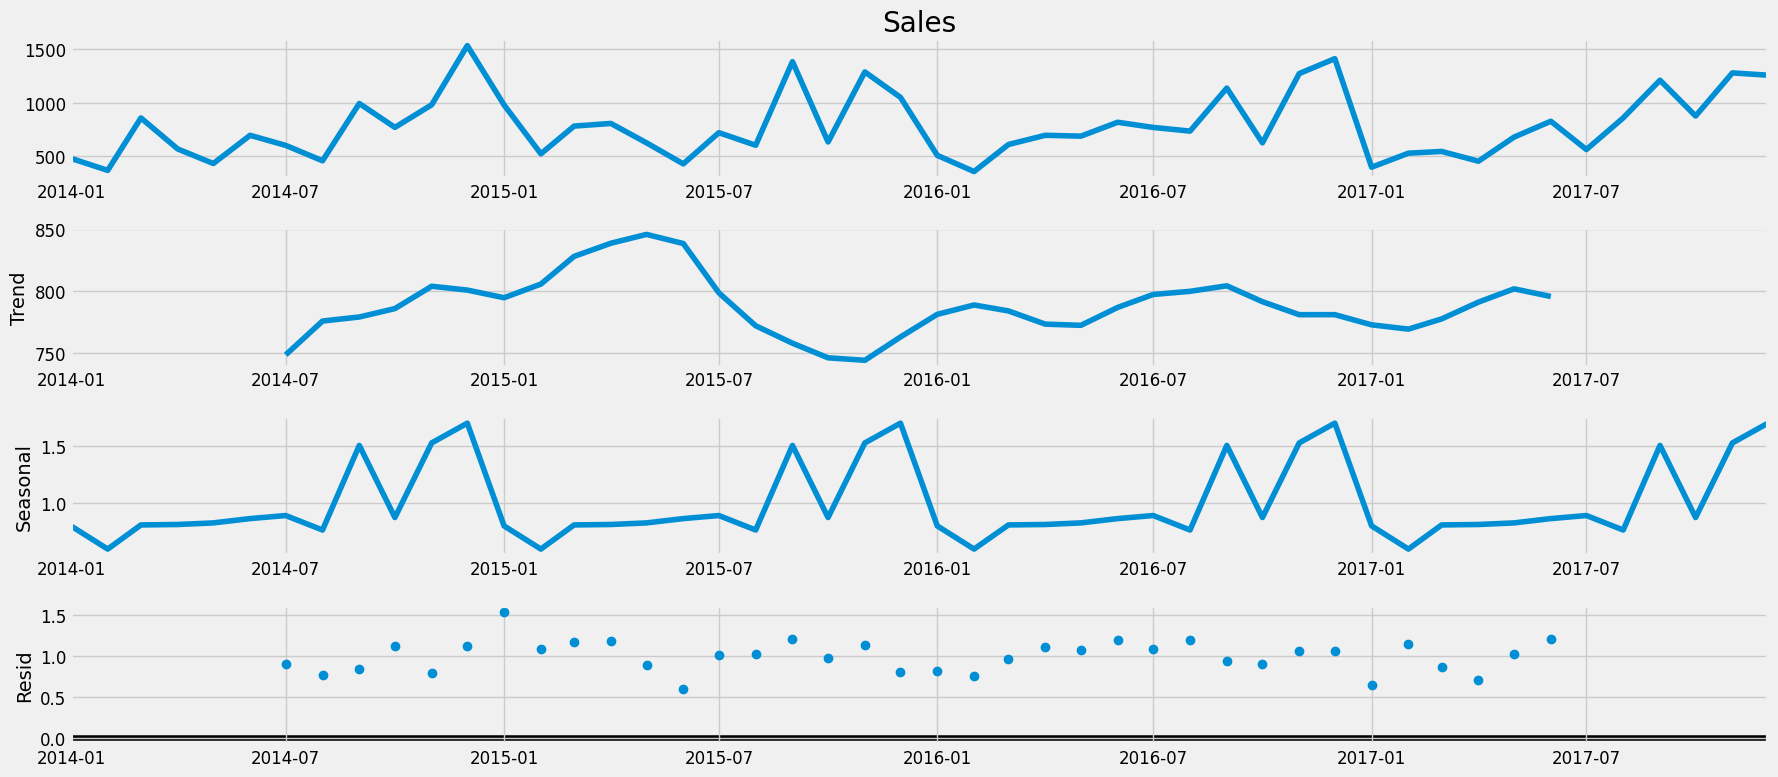

In [141]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

##**Stationarity**
Fitting an ARIMA model requires the series to be stationary. A series is said to be stationary when its mean, variance, and autocovariance are time invariant. Since ARIMA uses previous lags of series to model its behavior, modeling stable series with consistent properties involves less uncertainty.

What exactly does it mean for data to be stationary?

The mean of the series should not be a function of time.
The variance of the series should not be a function of time. This property is known as homoscedasticity.
Finally, the covariance of the i th term and the (i + m) th term should not be a function of time.
Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

The augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

##**Augmented Dickey-Fuller test**
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure).

The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0):

If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1):

The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
The statsmodels library provides the adfuller() function that implements the test.

In [142]:
#ADF Test
adfuller(df['Sales'])

(-99.26079402596326,
 0.0,
 0,
 9993,
 {'1%': -3.431004556246501,
  '5%': -2.8618292749021865,
  '10%': -2.5669239758928017},
 156374.38098455273)

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.



In [143]:
# ADF Test with better readable output
result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -99.26079402596326
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Running the example prints the test statistic value. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the significance of the ADF statistic.

The result suggests that we can't reject the null hypothesis. Not rejecting the null hypothesis means that the process has a unit root, and in turn that the time series is non-stationary (this means it does have a time-dependent structure).

##**Differencing**
Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. The difference is calculated by subtracting one period's values from the previous period's values.

The number of differences performed is represented by the d component of ARIMA. Now, we move on to diagnostics that can help determine the order of differencing.

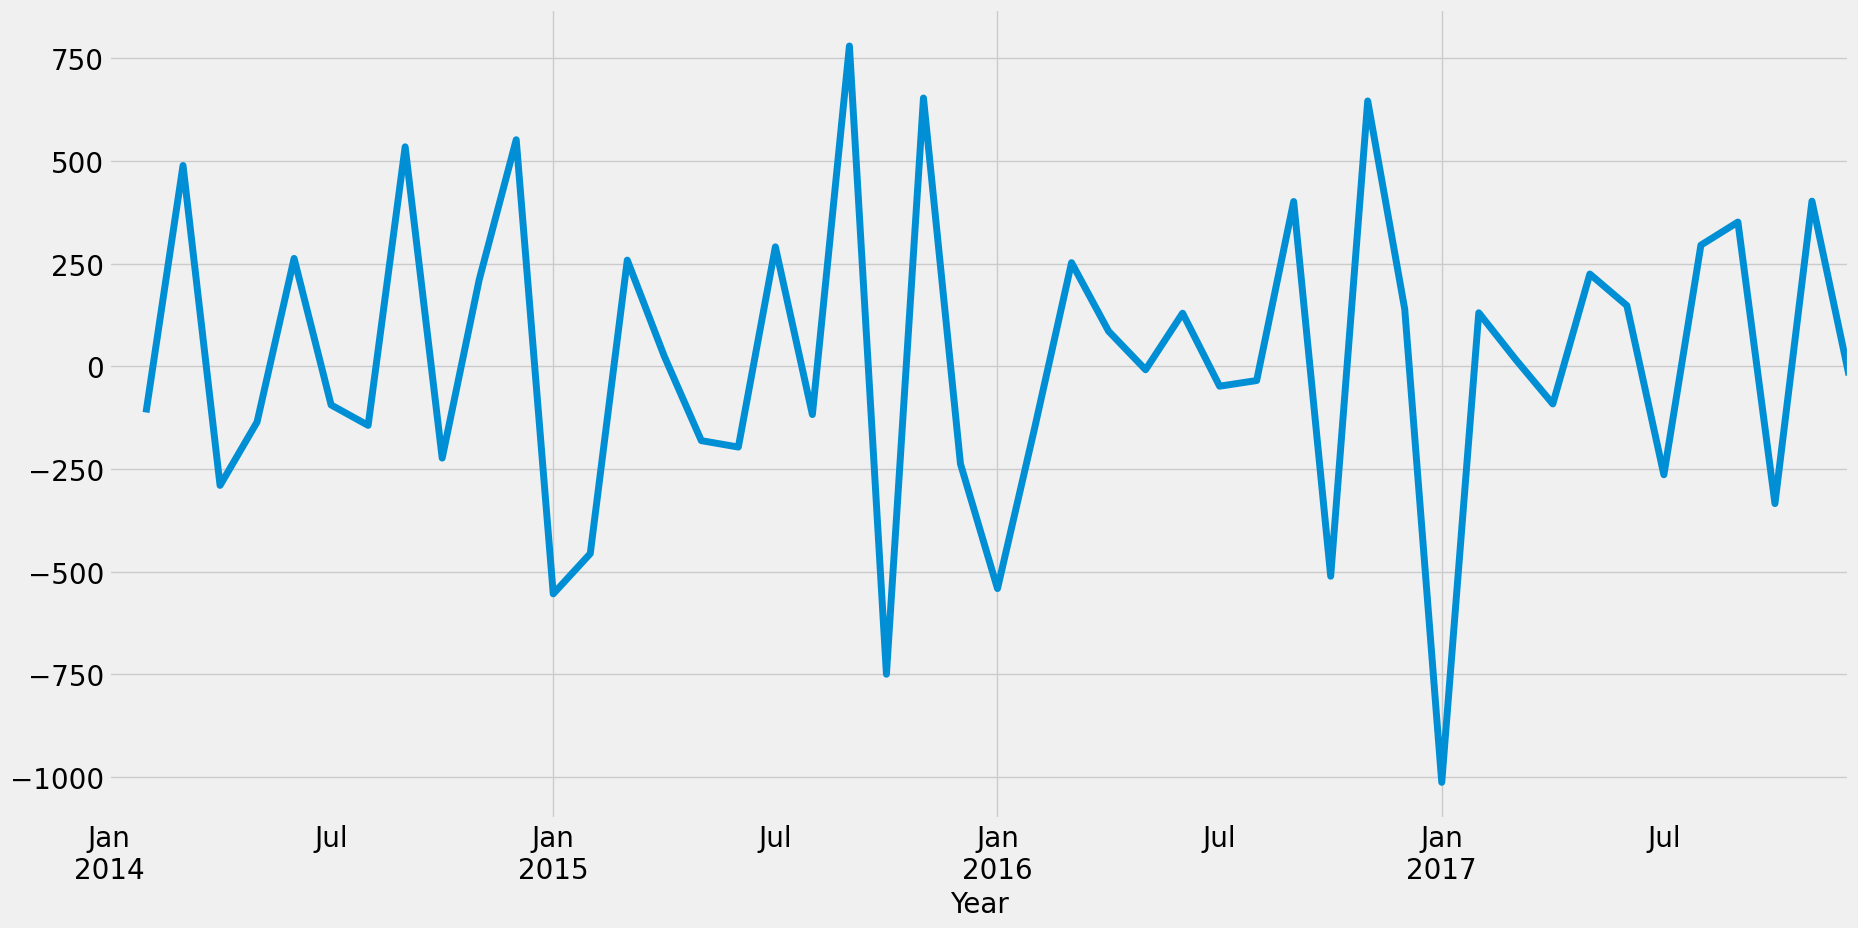

In [144]:
y.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

See that you have removed much of the trend and you can see the peaks in every year.

Note: you can also perform 2nd order differencing, which means that you would be looking at the difference between one data point and the two that precede it, if the trend is not yet entirely removed. See here for more on differencing.

##**Autocorrelations and Choosing Model Order**
Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time. If time series is random, such autocorrelations should be near zero for any and all time-lag separations.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model.

Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots. Source

Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

In [ ]:
autocorrelation_plot(y);

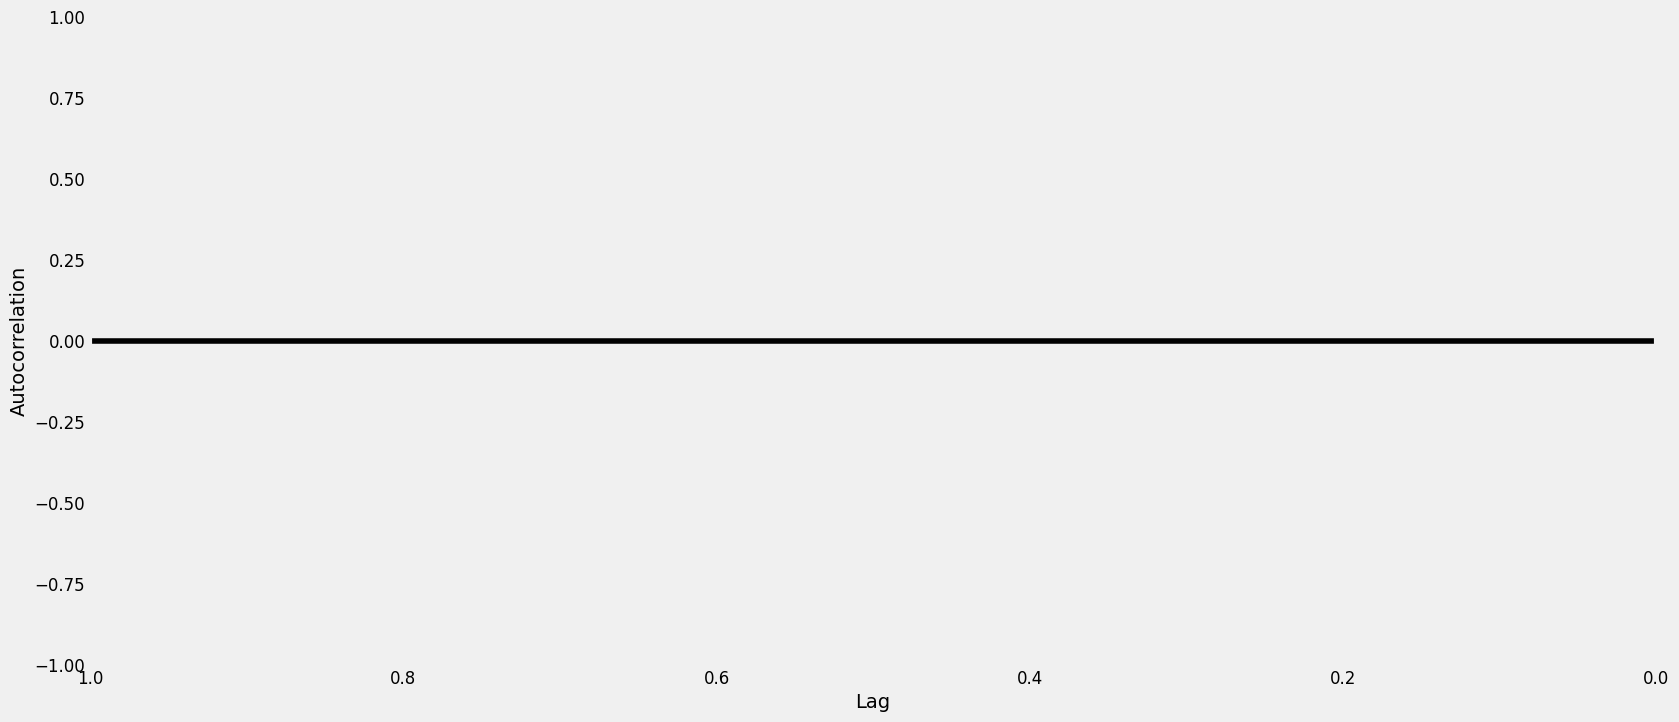

In [146]:
autocorrelation_plot(df2);

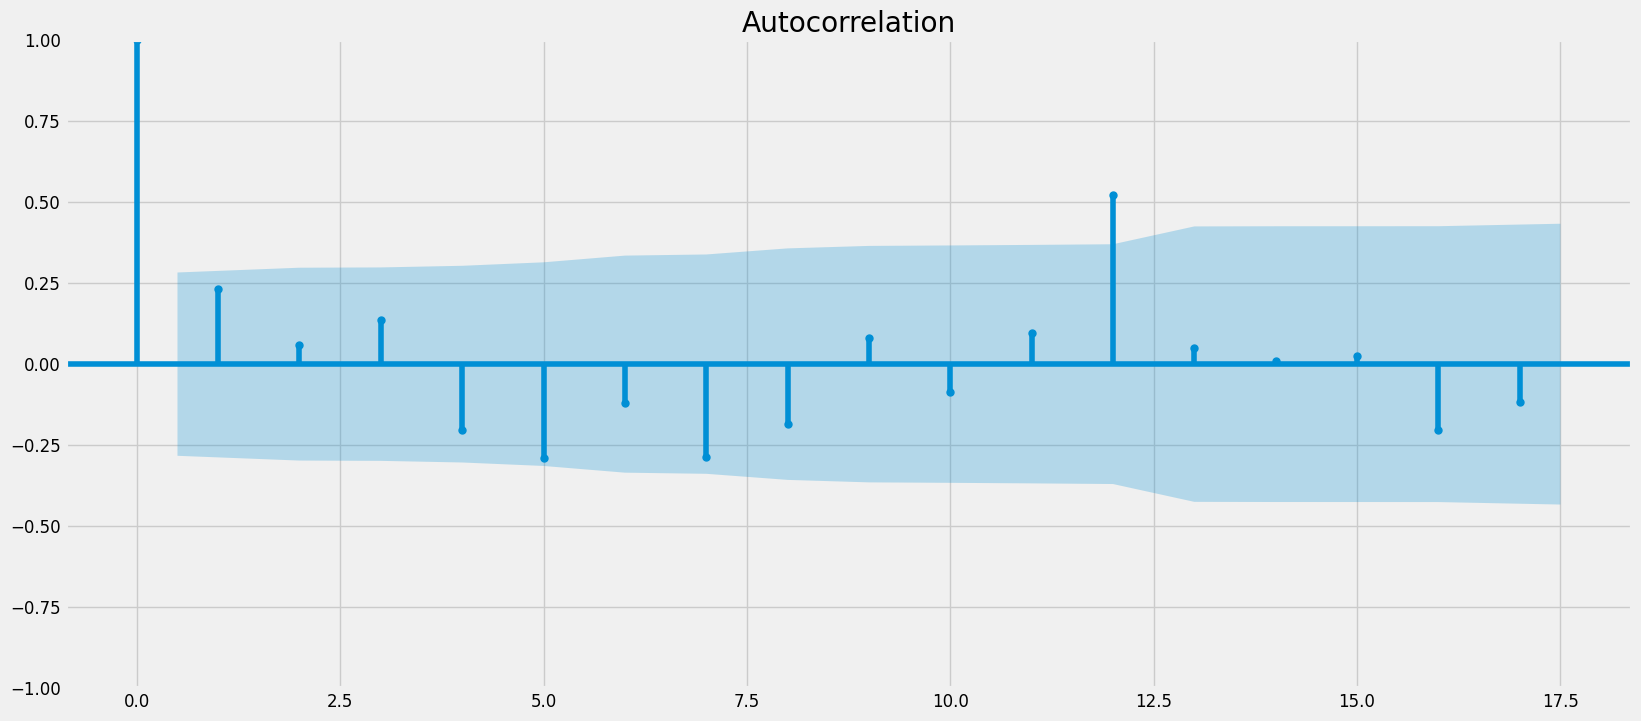

In [147]:
plot_acf(y);

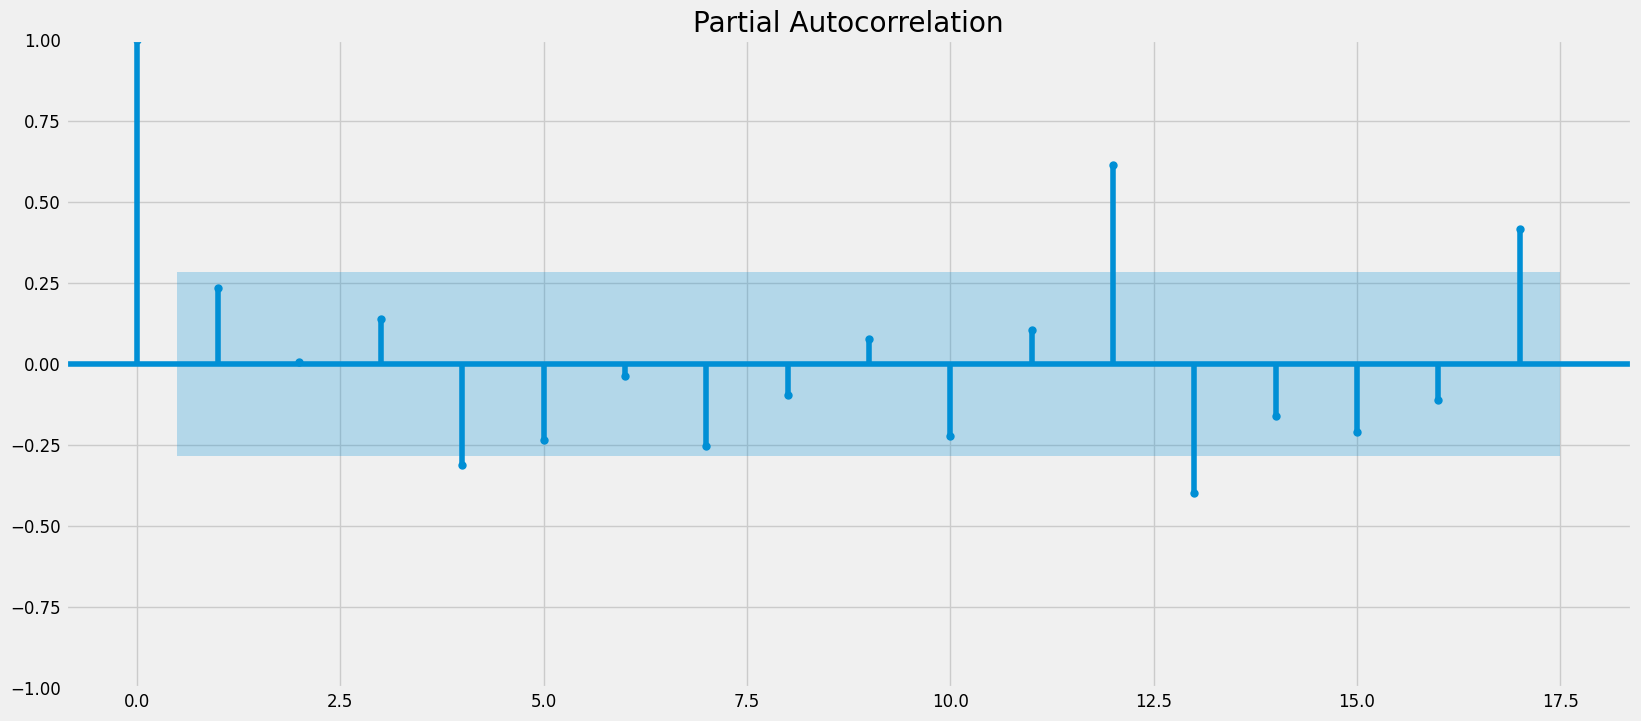

In [149]:
plot_pacf(y);

#**Time series forecasting with ARIMA**
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [151]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [152]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1523.5085449297978
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1317.1698862853953
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803033336
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758099
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2715.646290524748
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673299
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.61482929923943
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2505.9754087946067
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576437098
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668259312
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1362.3338317546836
AR

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

##**Fitting the ARIMA model**

In [153]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04


We should always run model diagnostics to investigate any unusual behavior.

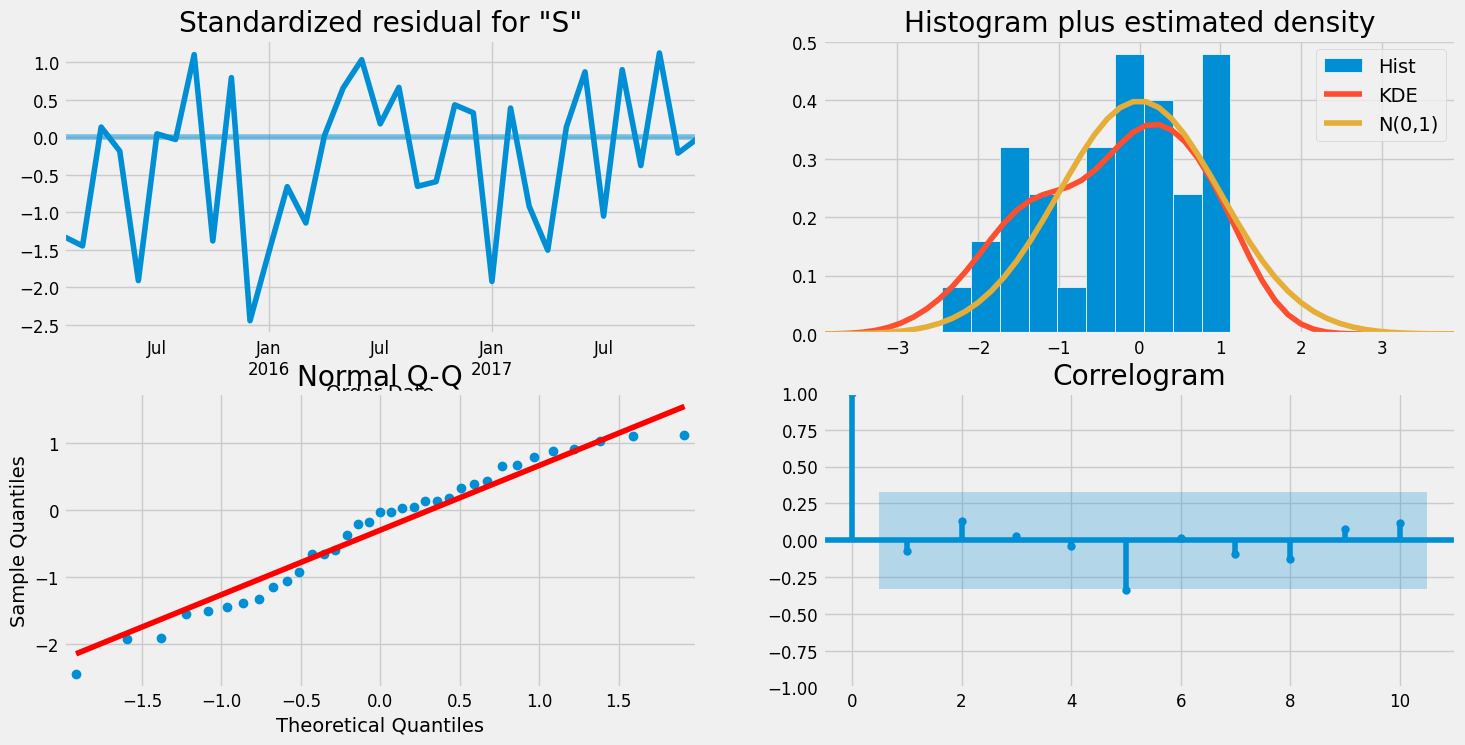

In [154]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

##**Validating forecasts**
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

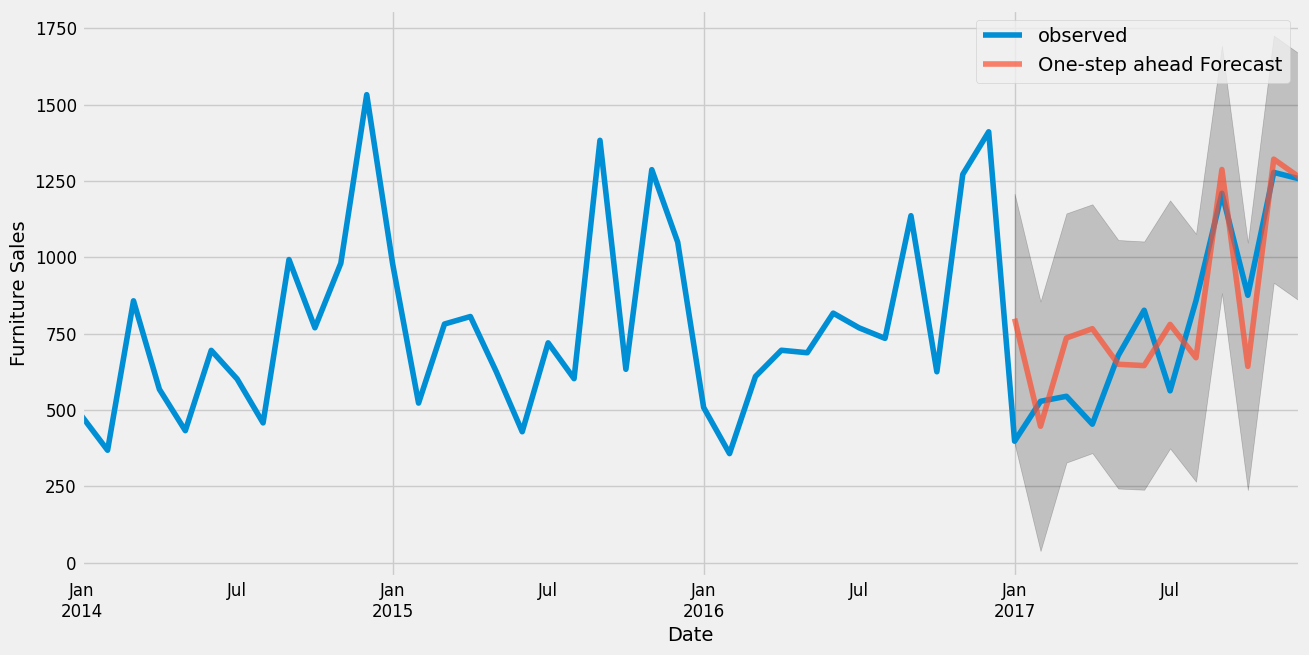

In [155]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [156]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 39996.01


In [157]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 199.99


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.



##**Producing and visualizing forecasts**

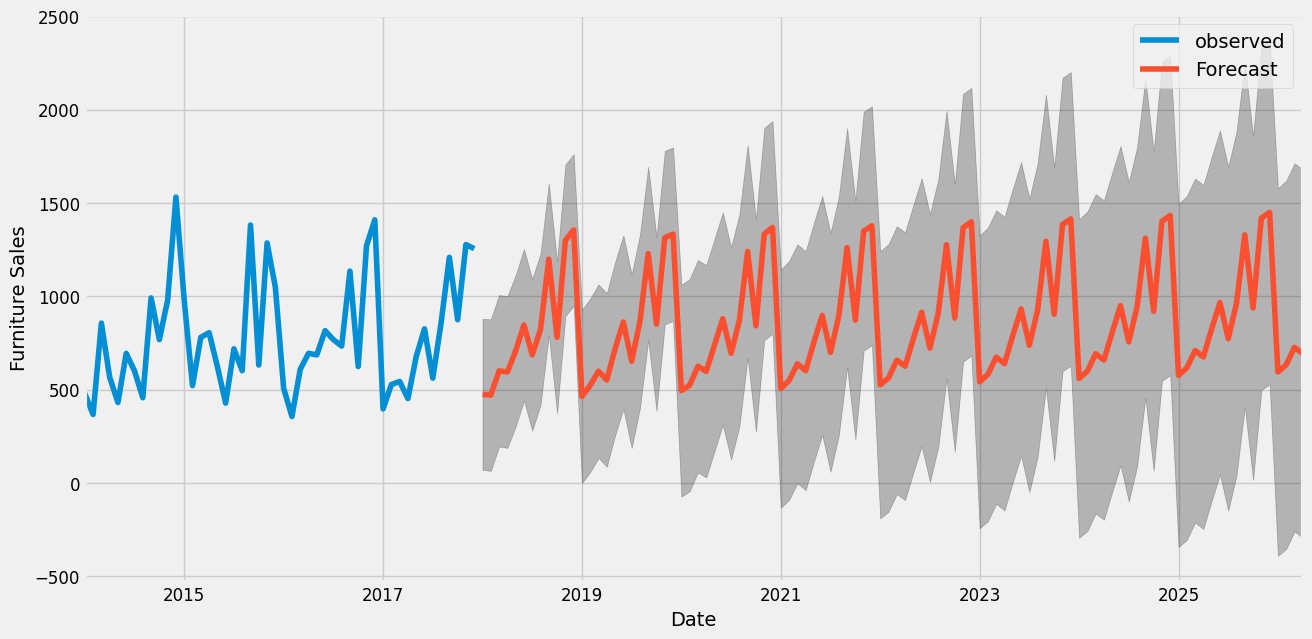

In [158]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier.

##**Time Series of Furniture vs. Office Supplies**
According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [159]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

##**Data Exploration**
We are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

In [160]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


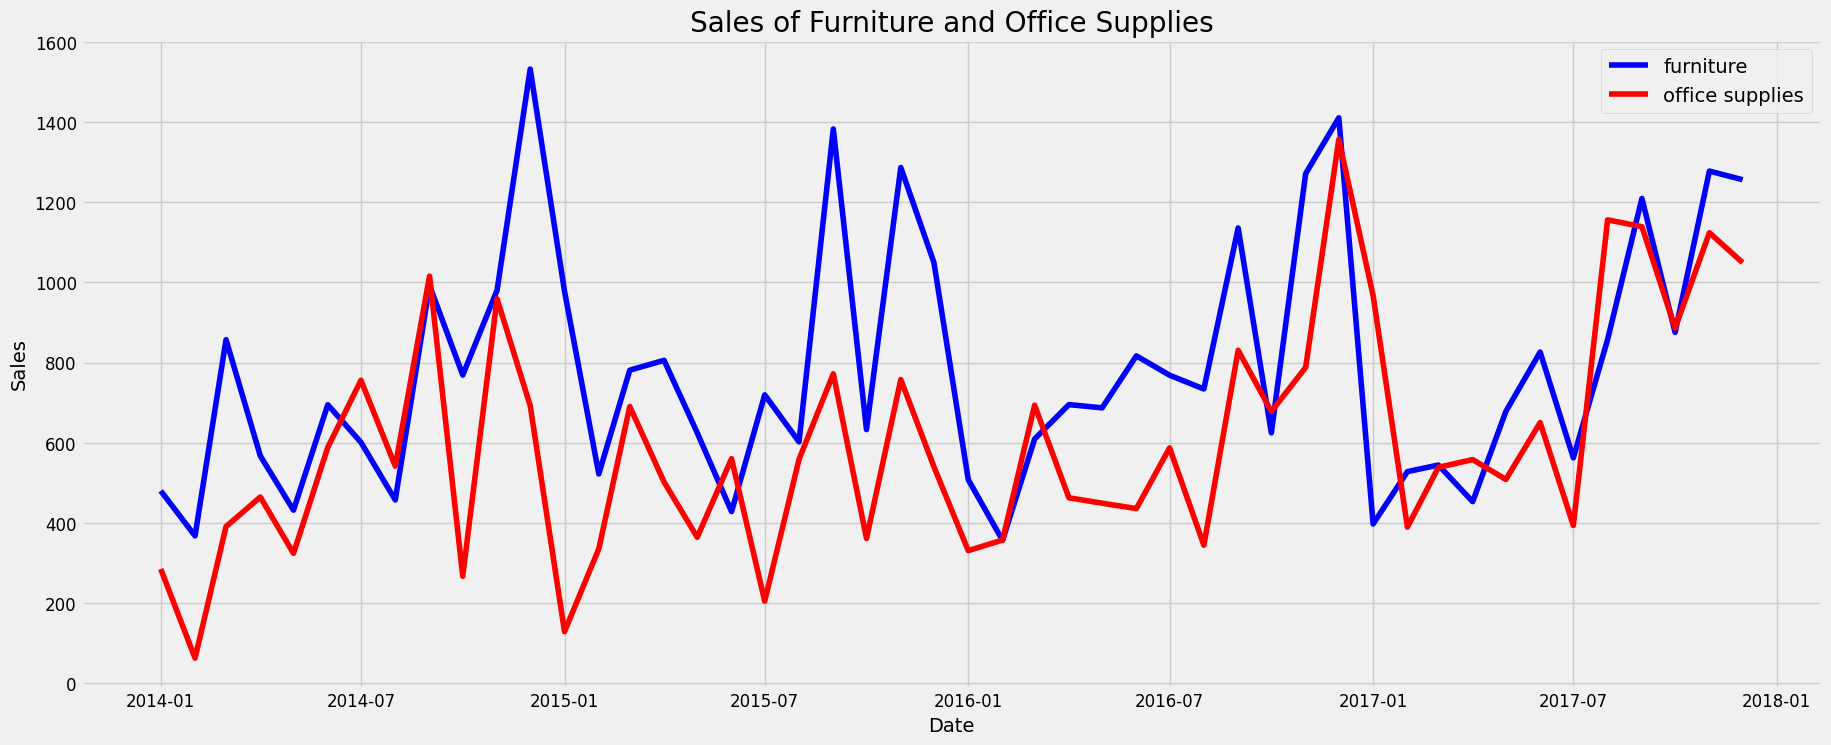

In [161]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.

In [162]:
first_date = store.iloc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), store.columns.get_loc('Order Date')]
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


##**Time Series Modeling with Prophet**
Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo8ord82e/s8yhu2fx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo8ord82e/vmpbjs2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52977', 'data', 'file=/tmp/tmpo8ord82e/s8yhu2fx.json', 'init=/tmp/tmpo8ord82e/vmpbjs2e.json', 'output', 'file=/tmp/tmpo8ord82e/prophet_modelv8w65uj2/prophet_model-20230509111956.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

<Figure size 1800x600 with 0 Axes>

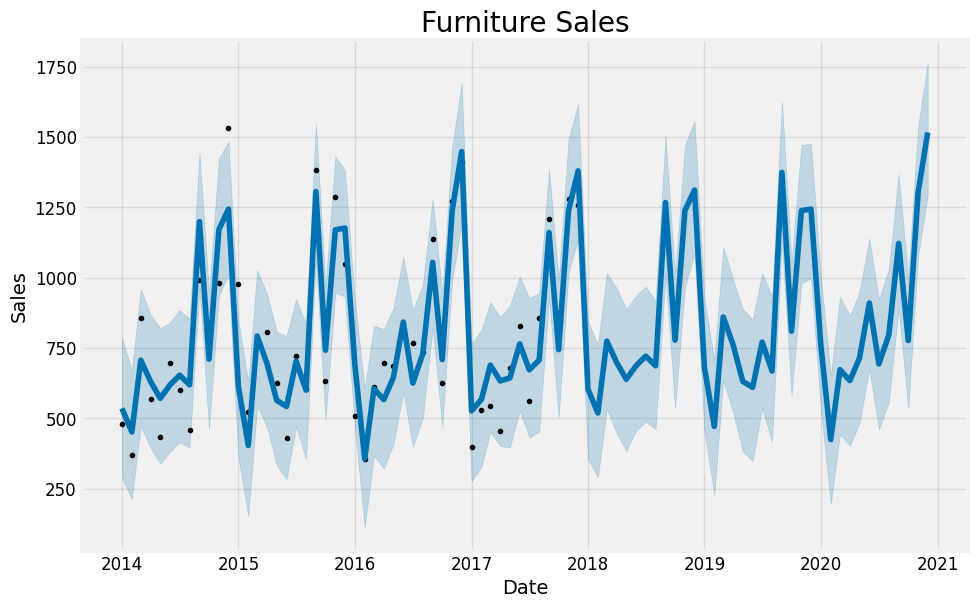

In [163]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1800x600 with 0 Axes>

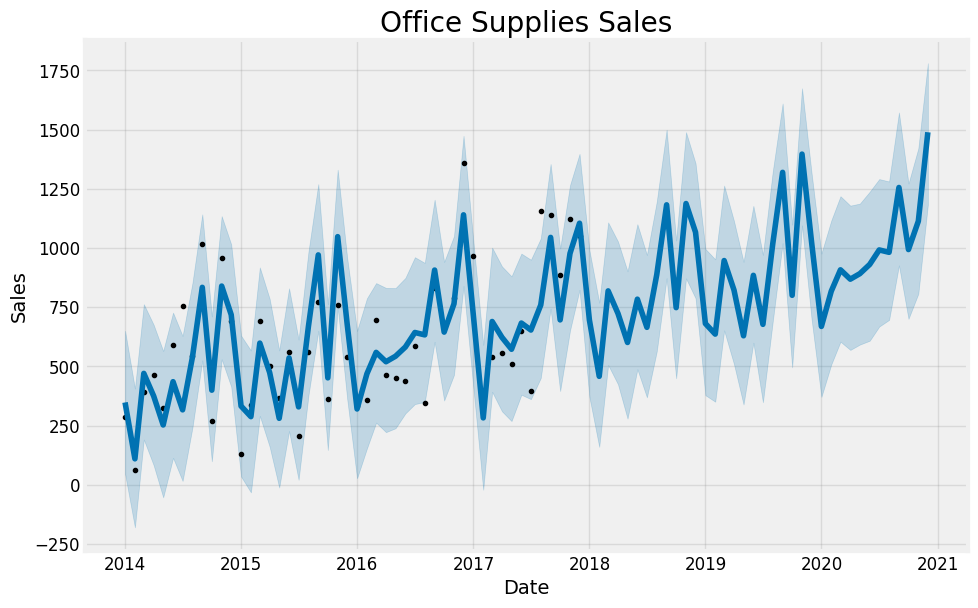

In [164]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

##**Compare Forecasts**
We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [165]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,288.714910,785.421861,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,212.917462,669.329562,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,472.423756,959.119059,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,393.976117,866.930281,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,338.591362,819.903772,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


##**Trend and Forecast Visualization**

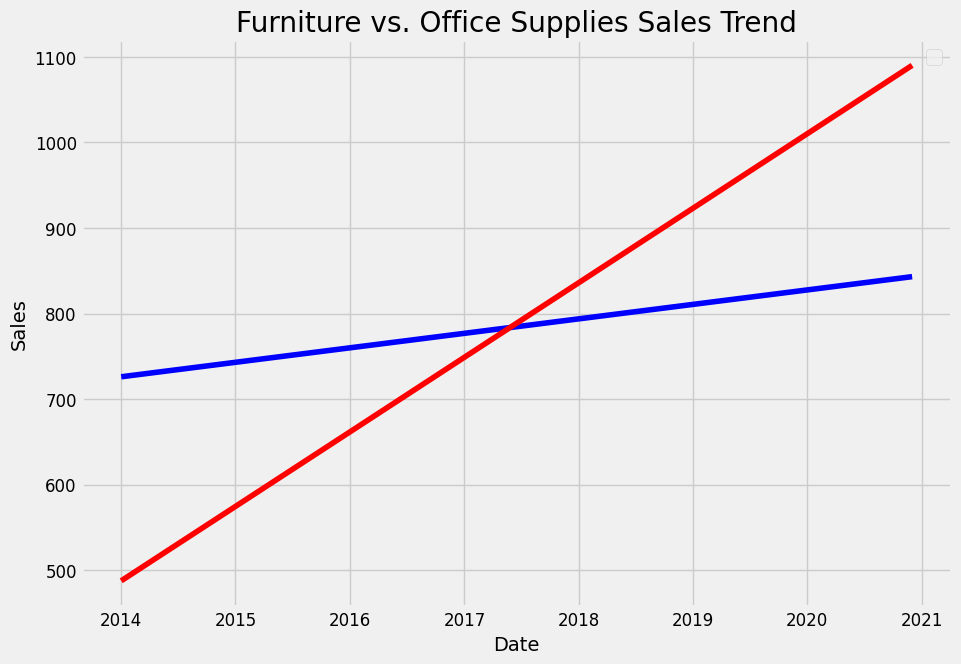

In [166]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

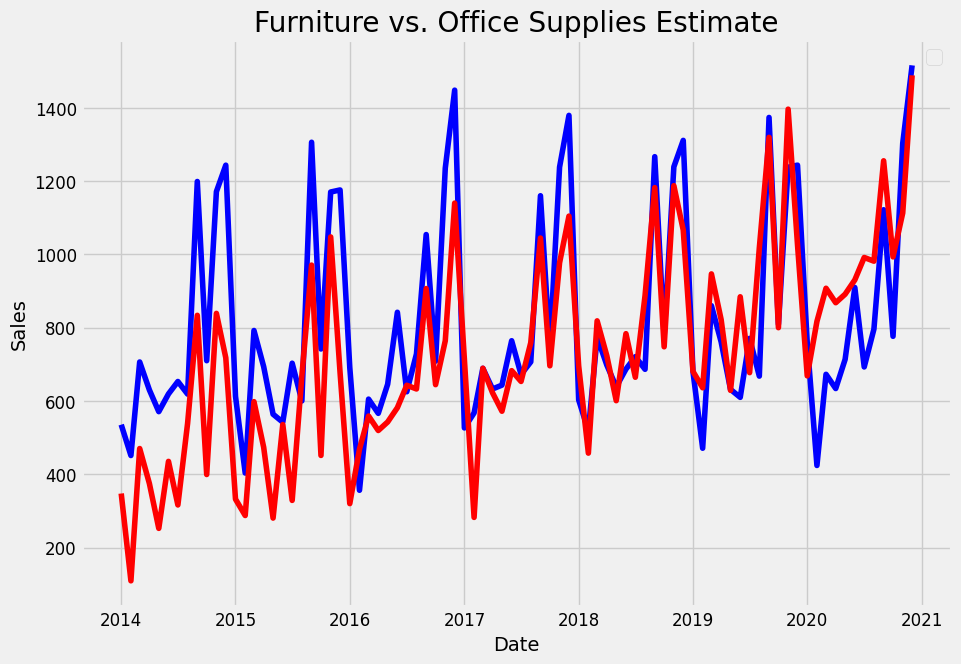

In [167]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

##**Trends and Patterns**
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

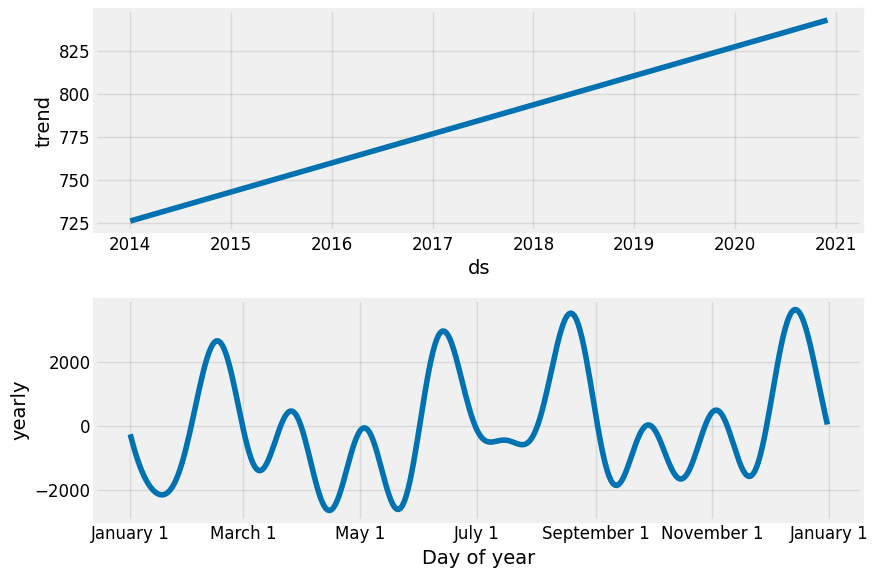

In [168]:
furniture_model.plot_components(furniture_forecast);

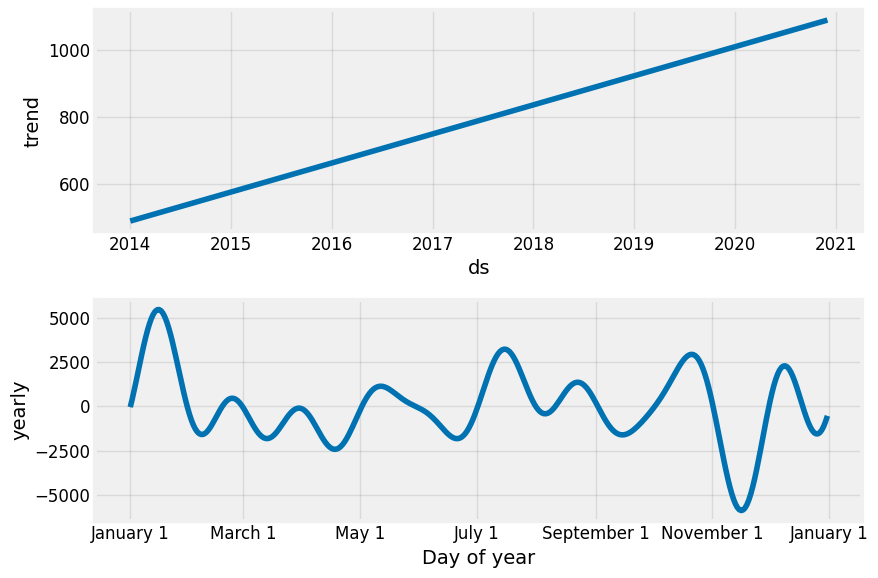

In [169]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is October.

#**MLP SERVICE**

In [178]:
# split dataset
df_train, df_test = train_test_split(y, train_size=0.7, shuffle=False)

# display training dataset length
print(f"The length of training dataset is: {len(df_train)}")

# display test dataset length
print(f"The length of test dataset is: {len(df_test)}")

The length of training dataset is: 33
The length of test dataset is: 15


In [195]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train['furniture_forecast'].values.reshape(-1,1))
test_scaled = scaler.transform(df_test['furniture_forecast'].values.reshape(-1,1))

NameError: ignored

In [176]:
# write a helper function which slices through the features using the sequence_length parameter and index the labe at the time step
# function should return features in sequence and labels
def sequencing_data(data, sequence_length):
    """
    Helper function to sample sub-sequence of training data.
    Input data must be in np.ndarray.
    """
    x, y = [], []

    for i in range(data.shape[0] - sequence_length):

        # copy the sequences of data starting at this index
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return x, y

# calling the helper function and store them in variables
X_sequence_train, y_sequence_train = sequencing_data(train_scaled, 3)
X_sequence_test, y_sequence_test = sequencing_data(test_scaled, 3)

# sanity check 
print("Total samples for X train: " + str(len(X_sequence_train)))
print("Total samples for y train: " + str(len(y_sequence_train)))
print("Total samples for X test: " + str(len(X_sequence_test)))
print("Total samples for y test: " + str(len(y_sequence_test)))

NameError: ignored

###It's about time to declare our MLP model architecture. The following code demonstrates how to build a simple MLP model.


In [ ]:
class MLP(nn.Module):
    """MLP model with configurable input size and output size."""
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_size, 64)
        self.linear1 = nn.Linear(64, 16)
        self.output = nn.Linear(16, output_size)
    
    def forward(self, x):
        x = x.view(-1, 1, 3)
        out = F.relu(self.input(x))
        out = F.relu(self.linear1(out))
        out = self.output(out)
        return out

Before we can start our training, we also need to configure some hyperparameters. Let's do that.

In [ ]:
# reproducibility
torch.manual_seed(38)

# setting hyperparameter
input_size = 3
output_size = 1
epochs = 100
learning_rate = 0.001

# instantiate the model
model = MLP(input_size, output_size)

# continue setting hyperparameter
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

We can perform our model training now. In torch, we need to manually write codes to implement model training.

In [ ]:
# implement model training and validation loop
loss_score = {'train': [], 'test': []}
for epoch in range(epochs):
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        for i, (X, y) in enumerate(DataLoader[phase]):
            with torch.set_grad_enabled(phase == 'train'):
                out = model(X)
                loss = criterion(out.squeeze(), y.squeeze())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)

TypeError: ignored

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


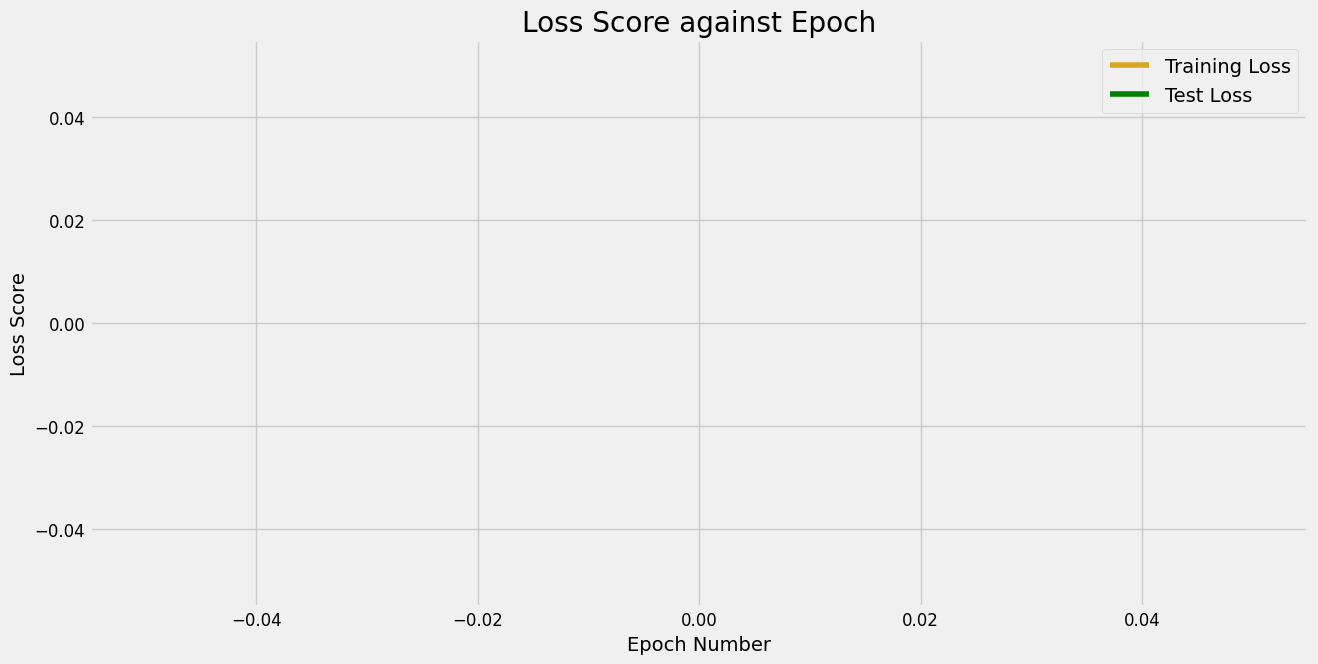

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")

ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['test'], color='green', label='Test Loss')
ax.legend();

#**Evaluation**
There are a few metrics that can be used to evaluate the performance of a regression model, which include:

mean squared error (MSE)
root mean squared error (RMSE)
mean absolute error (MAE)
We will examine the performance of the model on test set using RMSE.

In [ ]:
model.eval()

predictions = []
count = 0

# model predictions
with torch.no_grad():
    for i, (X, y) in enumerate(DataLoader(test_Dataset, 1)):
        count += 1
        output = model(X)
        predictions.append(output.item())
        
# convert list into np array and inverse transform it into proper values before feature scaling
predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(1,-1))

# remove beginning 3 rows of data since at least 3 data are needed to make a prediction
df_test = df_test.iloc[3:]
df_test['preds'] = predictions.squeeze()

# compute MSE
RMSE = mean_squared_error(df_test.preds, df_test.sales, squared=False)
print(f"The RMSE for the model is {RMSE}")

NameError: ignored